In [2]:
## imports
import pandas as pd
import numpy as np
import re
import requests
import yaml
import pickle
from statistics import mean
import os

import census
import janitor
from census import Census
import us
from us import states

from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import SMOTE

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import RocCurveDisplay
from sklearn.linear_model import LogisticRegression
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd


import contextily as ctx
## repeated printouts
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_colwidth', None)

import warnings
warnings.filterwarnings("ignore")

In [36]:
pwd

'C:\\Users\\Lahiri\\Gentrification\\Predicting-Gentrification-in-DC'

### Establishing connection to census

In [35]:
key = input("Enter census key:")
print(key)
conn = Census(key)

### Building query for pertinent demographic variables 

In [4]:
var = ( 'NAME', #required filed in api call, field only contains zip code. No use in final analyis
        'B01003_001E', #Total population
        'B02001_003E', # Black pop
        'B02001_002E', # white pop
        'B15001_001E', #- estimate total by education
        'B15001_017E',#bachelors men 25-34
        'B15001_018E',#masters men 25-34
        'B15001_025E',#bachlors men 35-44
        'B15001_026E',#and so on till age 65
        'B15001_033E',
        'B15001_034E',
        'B15001_041E',
        'B15001_042E',
        'B15001_058E',#bachelors women 25-34
        'B15001_059E',#and so on till age 65
        'B15001_066E',
        'B15001_067E',
        'B15001_074E',
        'B15001_075E',
        'B15001_082E',
        'B15001_083E',
        'B19301_001E', # per capita income overall
        'B19301A_001E',# per capita income for white population
        'B19301B_001E',# per capita income for black populaton
        'B01001_001E', # Total population by age 
        'B01001_002E', # Total male 
        'B01001_007E', 'B01001_008E','B01001_009E','B01001_010E','B01001_011E','B01001_012E',#total males 18-35
        'B01001_026E', #Total female 
        'B01001_031E','B01001_032E','B01001_033E','B01001_034E','B01001_035E', 'B01001_036E', #total females 18-35
        'B01001A_007E','B01001A_008E','B01001A_009E','B01001A_010E', #total white males 18-35
        'B01001A_022E','B01001A_023E','B01001A_024E','B01001A_025E', #total white females 18-35
        'B25064_001E', #Median rent
        'B25077_001E') #Median housing value (as estimated by respondant)



In [5]:
g = globals()
for i in range(2012,2022):
    varname = 'acs_{}'.format(i) ##iteratively create variable with format acs_'year'
    
    ##create dataframe for that particular year, get data at zipcode level
    g[varname] = pd.DataFrame(conn.acs5.get(var, geo={'for': 'tract:*', 'in': 'state:11'}, year = i))
    
    ## adding year column 
    g[varname]['Year'] = i 

In [6]:
#getting proportion of long term residents defined as more than 10 years in that tract. 
var_12_14 = ('NAME','B25026_001E','B25026_005E','B25026_006E','B25026_007E','B25026_008E', 'B25026_012E','B25026_013E','B25026_014E','B25026_015E')
var_15_17 = ('NAME','B25026_001E','B25026_005E','B25026_006E','B25026_007E','B25026_008E', 'B25026_012E','B25026_013E','B25026_014E','B25026_015E')
var_18_21 = ('NAME','B25026_001E','B25026_006E','B25026_007E','B25026_008E', 'B25026_013E','B25026_014E','B25026_015E')
g = globals()

for i in range(2012,2022):
    if i <=2014: 
        var = var_12_14
    elif i >= 2015 & i<=2017: 
        var = var_15_17
    else: 
        var = var_18_21
    varname = 'tenure_{}'.format(i) ##iteratively create variable with format acs_'year'
    
    ##create dataframe for that particular year, get data at zipcode level
    g[varname] = pd.DataFrame(conn.acs5.get(var, geo={'for': 'tract:*', 'in': 'state:11'}, year = i))
    
    ## only need he proportion of long term reisdence so can include in this loop
    g[varname].drop(columns = ['state','county','tract'], inplace = True)
    g[varname]['prop_long_res'] = (g[varname].iloc[:,2:].sum(axis = 1)/+ 1)/g[varname]['B25026_001E']
    g[varname] = g[varname][['NAME','prop_long_res']]




In [7]:
#merge main variable table with proportion of long term residence table for each year.
for i in range(2012,2022):
    varname1 = 'acs_{}'.format(i)
    varname2 = 'tenure_{}'.format(i)
    g[varname1] = g[varname1].merge(g[varname2], left_on = "NAME", right_on = "NAME", how = 'left')
    
#concat everything to create panel data from 2012-2021
acs_9yr = pd.concat([acs_2012,acs_2013,acs_2014,acs_2015,acs_2016,acs_2017,acs_2018,acs_2019,acs_2020, acs_2021]) 

rename_columns = {
'zip code tabulation area':'Zip',
'B25077_001E' : 'median_house_val',
'B19301_001E' : 'pcap_inc_overall', 
'B19301A_001E' : 'pcap_inc_w',
'B19301B_001E' : 'pcap_inc_b',
'B01003_001E' : 'tot_pop',
'B02001_003E' : 'black_pop',
'B02001_002E' : 'white_pop',
'B07010_001E' :'tot_income', 
'B25064_001E' : 'median_rent',
'B25077_001E': 'median_hous',
'B06009_006E' : "grad_deg"}
acs_9yr = acs_9yr.rename(columns = rename_columns)

### Feature generation and data cleaning

In [8]:
acs_9yr = acs_9yr[acs_9yr['tot_pop']>0] #only keep census tracts with non zero poulation

#create proportion wise variables 
acs_9yr['prop_black'] = acs_9yr['black_pop']/acs_9yr['tot_pop']
acs_9yr['prop_nwhite'] = 1 - acs_9yr['white_pop']/acs_9yr['tot_pop']

 #proportion of females and population aged 18-35
acs_9yr['perc_fem'] = acs_9yr['B01001_026E']/(acs_9yr['B01001_026E']+acs_9yr['B01001_002E']) 
acs_9yr['perc_young_pop'] = acs_9yr[['B01001_007E', 'B01001_008E','B01001_009E','B01001_010E','B01001_011E','B01001_012E','B01001_031E','B01001_032E','B01001_033E','B01001_034E','B01001_035E', 'B01001_036E']].sum(axis = 1)/acs_9yr['B01001_001E']

#proportion with bachelors+ degree between 25 and 65
acs_9yr['prop_bach'] = acs_9yr[[
                                'B15001_017E',
                                'B15001_018E',
                                'B15001_025E',
                                'B15001_026E',
                                'B15001_033E',
                                'B15001_034E',
                                'B15001_041E',
                                'B15001_042E',
                                'B15001_058E',
                                'B15001_059E',
                                'B15001_066E',
                                'B15001_067E',
                                'B15001_074E',
                                'B15001_075E',
                                'B15001_082E',
                                'B15001_083E']].sum(axis=1)/ acs_9yr['B15001_001E']

In [9]:
 ## removing zero or negative populations

#Negative values in the following fields implies that population is composed only of one race so per capita income for 
##other race is a system generated negative number. Therefore replacing with zeros. 
acs_9yr['pcap_inc_w'] = np.where(acs_9yr['pcap_inc_w'] < 0,0,acs_9yr['pcap_inc_w'])
acs_9yr['pcap_inc_w'] = np.where((acs_9yr['pcap_inc_w'].isna()) & (acs_9yr['white_pop'] == 0) ,0,acs_9yr['pcap_inc_w'])
acs_9yr['pcap_inc_b'] = np.where((acs_9yr['pcap_inc_b'].isna()) & (acs_9yr['black_pop'] == 0),0,acs_9yr['pcap_inc_b'])
acs_9yr['pcap_inc_b'] = np.where(acs_9yr['pcap_inc_b'] < 0,0,acs_9yr['pcap_inc_b'])


acs_9yr['prop_long_res'] = acs_9yr['prop_long_res'].fillna(0)

#for negative values in median rent, it is simply a missing value. Converting to Nan for imputation later on 
acs_9yr['median_rent'] = np.where(acs_9yr['median_rent'] < 0,np.nan,acs_9yr['median_rent'])
acs_9yr['median_hous'] = np.where(acs_9yr['median_hous'] < 0,np.nan,acs_9yr['median_hous'])

In [10]:
acs_9yr= acs_9yr[['state',
                  'tract',
                  'Year',
                  'tot_pop',
                  'prop_black',
                  'prop_nwhite', 
                  'prop_bach',
                  'pcap_inc_overall',
                  'pcap_inc_w',
                  'pcap_inc_b',
                  'prop_long_res',
                  'perc_fem',
                  'perc_young_pop',
                  'median_hous',
                  'median_rent']]

### Inflation adjusting to 2021 using cpi data

In [11]:
#inflation adjusting to 2021 for all years. 
cpi = pd.read_csv('./data/cpi.csv').iloc[:,0:2]
cpi['infl_factor'] = [cpi[cpi.YEAR == 2021]['AVG'].values[0]/cpi[cpi.YEAR == i]['AVG'].values[0] for i in range(2012,2022)]

In [12]:
#inflation adjusting for columns with monetary values 
acs_9yr = pd.merge(acs_9yr, cpi, left_on = 'Year', right_on = 'YEAR')
for j in ['pcap_inc_overall','pcap_inc_w','pcap_inc_b','median_hous','median_rent']:
    acs_9yr[j]=acs_9yr[j]*acs_9yr['infl_factor']

#reordering columns again
acs_9yr= acs_9yr[['state',
                  'tract',
                  'Year',
                  'tot_pop',
                  'prop_black',
                  'prop_nwhite', 
                  'prop_bach',
                  'pcap_inc_overall',
                  'pcap_inc_w',
                  'pcap_inc_b',
                  'prop_long_res',
                  'perc_fem',
                  'perc_young_pop',
                  'median_hous',
                  'median_rent']]
acs_9yr = acs_9yr.reset_index().drop(columns = 'index')

In [13]:
#replacing zero values with minimum in column, since we will later be calculating percentage changes and initial values cannot be zero.
for i in acs_9yr.iloc[:,3:].columns:
    acs_9yr[i] = np.where(acs_9yr[i]== 0,acs_9yr[acs_9yr[i] > 0][i].min(),acs_9yr[i])

### Multiple imputation for missing data

In [14]:
impute_df = acs_9yr.copy()
impute_df = impute_df.iloc[:,3:]

In [15]:
imputer = IterativeImputer(max_iter = 5000, random_state= 42)
imputed = imputer.fit_transform(impute_df)
acs_9yr_imputed = pd.DataFrame(imputed, columns=impute_df.columns)

round(acs_9yr_imputed, 10)

,tot_pop,prop_black,prop_nwhite,prop_bach,pcap_inc_overall,pcap_inc_w,pcap_inc_b,prop_long_res,perc_fem,perc_young_pop,median_hous,median_rent
0,2591.0,0.049016,0.111926,0.804450,92688.586667,98046.417778,39747.493333,0.380671,0.530297,0.379390,860303.111111,1756.782222
1,3267.0,0.649219,0.697888,0.411297,38256.711111,80668.933333,16444.711111,0.249150,0.574227,0.341598,486366.222222,468.160000
2,2704.0,0.991124,0.991124,0.115286,21951.502222,42440.087061,21413.591111,0.381662,0.567308,0.187500,238808.888889,1029.715556
3,2271.0,0.994716,0.998239,0.044529,17242.711111,38537.713678,17222.613333,0.333185,0.560546,0.195068,237390.222222,998.977778
4,2157.0,0.407974,0.440890,0.579410,51624.097778,72238.506667,23970.737778,0.276044,0.576263,0.389893,663699.555556,1423.395556
...,...,...,...,...,...,...,...,...,...,...,...,...
1836,3634.0,0.858558,0.983214,0.138844,21977.000000,4849.000000,21205.000000,0.355319,0.455146,0.407815,318600.000000,1248.000000
1837,2385.0,0.331656,0.404612,0.705603,73420.000000,75321.000000,78489.000000,0.555975,0.535430,0.394549,398400.000000,1960.000000
1838,1519.0,0.157999,0.290323,0.757268,106678.000000,111423.000000,62535.000000,0.444520,0.541145,0.212640,407500.000000,1832.000000
1839,5192.0,0.692797,0.848613,0.369585,39253.000000,71305.000000,33927.000000,0.744508,0.471109,0.217065,553600.000000,1386.924535


In [16]:
acs_9yr = acs_9yr.reset_index().drop(columns = 'index')
acs_9yr_imputed.insert(0, 'Year', acs_9yr['Year'])
acs_9yr_imputed.insert(1, 'state', acs_9yr['state'])
acs_9yr_imputed.insert(2, 'tract', acs_9yr['tract'])

In [17]:
acs_9yr_imputed.to_hdf('acs_pre_clustering.h5', key='acs', mode='w')

### EDA 

Text(0.5, 0.98, 'Relationship b/w percentage of black population and median housing value (2012-2021)')

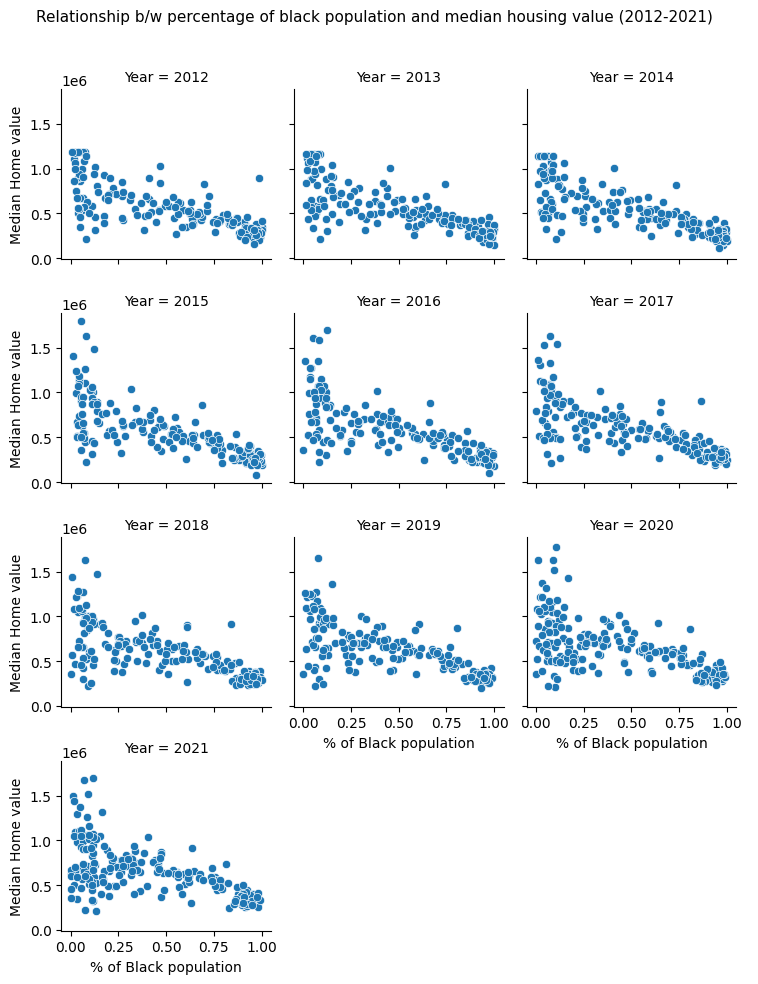

In [18]:
g = sns.FacetGrid(acs_9yr_imputed, col="Year", height=2.5, col_wrap=3)
g.map_dataframe(sns.scatterplot, x="prop_black", y="median_hous")
g.add_legend()
g.fig.subplots_adjust(top=0.9)
g.set(xlabel='% of Black population', ylabel='Median Home value')
g.fig.suptitle('Relationship b/w percentage of black population and median housing value (2012-2021)',fontsize=11)

Text(0.5, 0.98, 'Relationship b/w median housing value and median rent (2012-2021)')

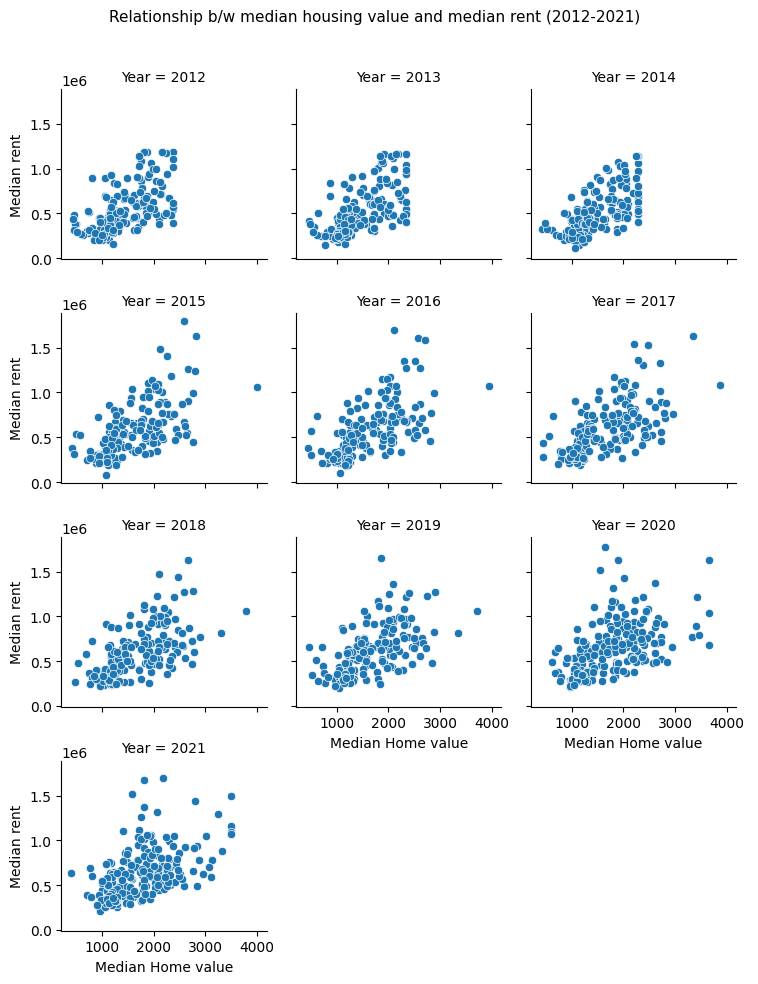

In [34]:
g = sns.FacetGrid(acs_9yr_imputed, col="Year", height=2.5, col_wrap=3)
g.map_dataframe(sns.scatterplot, x="median_rent", y="median_hous")
g.add_legend()
g.fig.subplots_adjust(top=0.9)
g.set(xlabel='Median Home value', ylabel='Median rent')

g.fig.suptitle('Relationship b/w median housing value and median rent (2012-2021)',fontsize=11)


In [19]:
acs_9yr_imputed.columns.tolist()

['Year',
 'state',
 'tract',
 'tot_pop',
 'prop_black',
 'prop_nwhite',
 'prop_bach',
 'pcap_inc_overall',
 'pcap_inc_w',
 'pcap_inc_b',
 'prop_long_res',
 'perc_fem',
 'perc_young_pop',
 'median_hous',
 'median_rent']

<Figure size 960x800 with 0 Axes>

Text(0.5, 1.0, 'Correlogram of demographics')

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5]),
 [Text(0.5, 0, 'Total Population'),
  Text(1.5, 0, 'Percentage of Black of population'),
  Text(2.5, 0, 'Percentage of non white population'),
  Text(3.5, 0, 'Percentage of Bachelors degree+ population'),
  Text(4.5, 0, 'Per capita income overall'),
  Text(5.5, 0, 'Per capita income - White population'),
  Text(6.5, 0, 'Per capita income - Black population'),
  Text(7.5, 0, 'Percentage of long term residents'),
  Text(8.5, 0, 'Percentage of female population'),
  Text(9.5, 0, 'Percentae of population 18-35'),
  Text(10.5, 0, 'Median Home Value'),
  Text(11.5, 0, 'Median rent')])

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5]),
 [Text(0, 0.5, 'Total Population'),
  Text(0, 1.5, 'Percentage of Black of population'),
  Text(0, 2.5, 'Percentage of non white population'),
  Text(0, 3.5, 'Percentage of Bachelors degree+ population'),
  Text(0, 4.5, 'Per capita income overall'),
  Text(0, 5.5, 'Per capita income - White population'),
  Text(0, 6.5, 'Per capita income - Black population'),
  Text(0, 7.5, 'Percentage of long term residents'),
  Text(0, 8.5, 'Percentage of female population'),
  Text(0, 9.5, 'Percentae of population 18-35'),
  Text(0, 10.5, 'Median Home Value'),
  Text(0, 11.5, 'Median rent')])

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5]),
 [Text(0.5, 0, 'Total Population'),
  Text(1.5, 0, 'Percentage of Black of population'),
  Text(2.5, 0, 'Percentage of non white population'),
  Text(3.5, 0, 'Percentage of Bachelors degree+ population'),
  Text(4.5, 0, 'Per capita income overall'),
  Text(5.5, 0, 'Per capita income - White population'),
  Text(6.5, 0, 'Per capita income - Black population'),
  Text(7.5, 0, 'Percentage of long term residents'),
  Text(8.5, 0, 'Percentage of female population'),
  Text(9.5, 0, 'Percentae of population 18-35'),
  Text(10.5, 0, 'Median Home Value'),
  Text(11.5, 0, 'Median rent')])

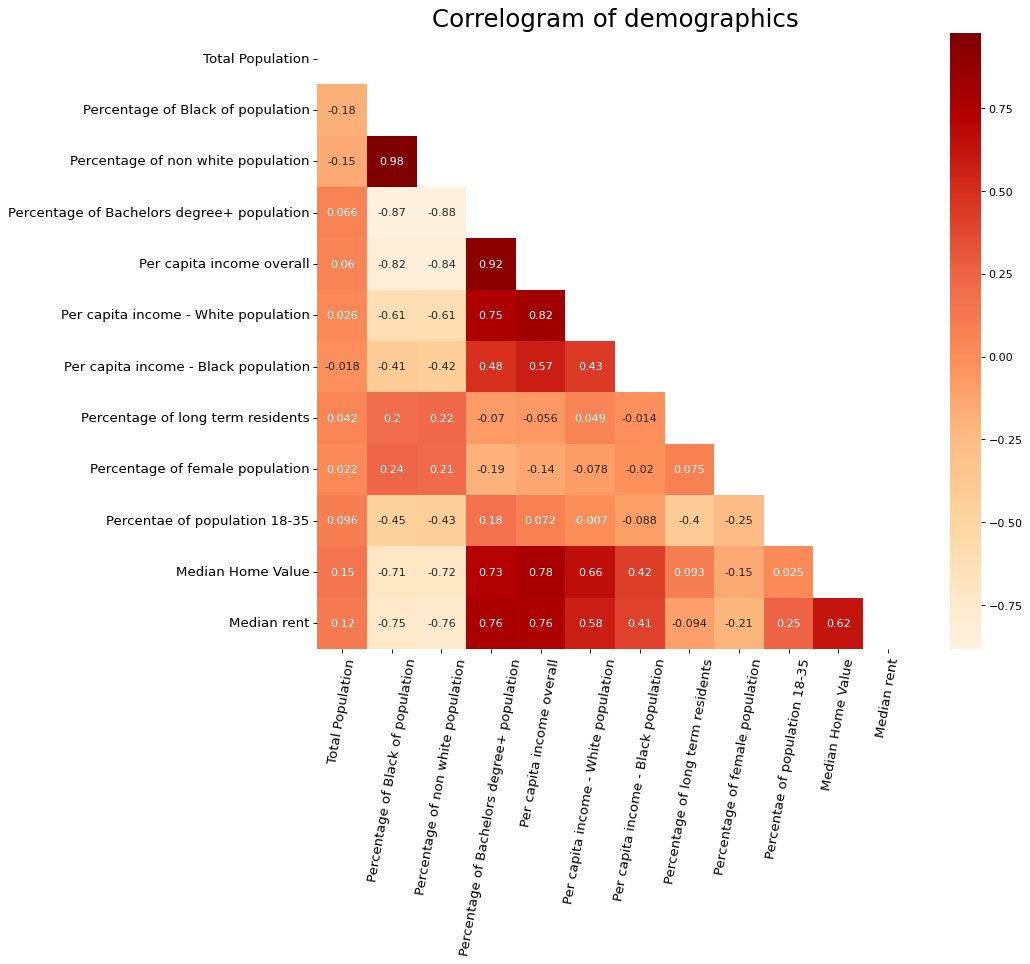

In [33]:
labels = ['Total Population',
                             'Percentage of Black of population',
                             'Percentage of non white population',
                             'Percentage of Bachelors degree+ population',
                             'Per capita income overall',
                             'Per capita income - White population',
                             'Per capita income - Black population',
                             'Percentage of long term residents',
                             'Percentage of female population',
                             'Percentae of population 18-35',
                             'Median Home Value',
                             'Median rent']

plt.figure(figsize=(12,10), dpi= 80)
cor = acs_9yr_imputed.loc[:, acs_9yr_imputed.columns != 'Year'].corr()
matrix = np.triu(cor)
g = sns.heatmap(cor, xticklabels=labels, yticklabels=labels, cmap='OrRd', mask = matrix,center=0, annot=True)

# Decorations
plt.title('Correlogram of demographics', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(rotation = 80)
plt.show()
